In [2]:
import pandas as pd
import numpy as np
import psycopg2

from matplotlib import pyplot as plt
import seaborn as sns

C:\Users\ddiaz\AppData\Local\Continuum\Anaconda2\envs\Py3.5\lib\site-packages\bokeh\util\deprecation.py:34: BokehDeprecationWarning: MPL compatibility can no longer be successfully maintained, and is now deprecated. All MPL compat functions will be removed completely on the release of Bokeh 1.0. See http://bokeh.pydata.org/en/latest/docs/releases/0.12.5.html for more information
  warn(message)
C:\Users\ddiaz\AppData\Local\Continuum\Anaconda2\envs\Py3.5\lib\site-packages\bokeh\util\deprecation.py:34: BokehDeprecationWarning: 
The bokeh.charts API has moved to a separate 'bkcharts' package.

This compatibility shim will remain until Bokeh 1.0 is released.
After that, if you want to use this API you will have to install
the bkcharts package explicitly.

  warn(message)


In [3]:
%matplotlib inline

Loading BokehJS ...

### Pull the timber and economic outputs from the Rotations database for each stand and prescription

In [139]:
conn = psycopg2.connect("dbname='Rotations' user='postgres' host='localhost'") # password in pgpass file
SQL = '''
SELECT summary.*, cases.variant
FROM summary, cases
WHERE summary.caseid = cases.caseid;
'''
# read the query into a pandas dataframe
Rotations = pd.read_sql(SQL, conn)

# close the database connection
conn.close()

In [140]:
Rotations.head()

,caseid,standid,year,age,tpa,ba,sdi,ccf,topht,qmd,...,attopht,atqmd,prdlen,acc,mort,mai,fortyp,sizecls,stkcls,variant
0,6cba1f48-a570-48ee-b433-7db93e987994,PN_110,0,0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.00000,3,0.0,0.0,0.0,999,5,5,PN
1,6cba1f48-a570-48ee-b433-7db93e987994,PN_110,3,3,450.0,0.0,2.0,9.0,7.0,0.30000,...,7.0,0.30000,3,15.0,0.0,0.0,201,3,3,PN
2,6cba1f48-a570-48ee-b433-7db93e987994,PN_110,6,6,441.0,6.0,22.0,40.0,15.0,1.53761,...,15.0,1.53761,3,43.0,0.0,0.0,201,3,3,PN
3,6cba1f48-a570-48ee-b433-7db93e987994,PN_110,9,9,433.0,18.0,54.0,64.0,23.0,2.72885,...,23.0,2.72885,3,79.0,1.0,0.0,201,3,3,PN
4,6cba1f48-a570-48ee-b433-7db93e987994,PN_110,12,12,424.0,32.0,88.0,87.0,30.0,3.74766,...,30.0,3.74766,3,289.0,3.0,0.0,201,3,3,PN


In [141]:
Rotations.columns

Index(['caseid', 'standid', 'year', 'age', 'tpa', 'ba', 'sdi', 'ccf', 'topht',
       'qmd', 'tcuft', 'mcuft', 'bdft', 'rtpa', 'rtcuft', 'rmcuft', 'rbdft',
       'atba', 'atsdi', 'atccf', 'attopht', 'atqmd', 'prdlen', 'acc', 'mort',
       'mai', 'fortyp', 'sizecls', 'stkcls', 'variant'],
      dtype='object')

In [142]:
Rotations['after_bdft'] = Rotations.bdft - Rotations.rbdft
stand_bdft = Rotations[['caseid', 'standid', 'year', 'after_bdft']].set_index(['caseid', 'standid', 'year'])
my_cols = ['caseid', 'standid', 'year', 'rbdft']
cum_rbdft = Rotations[my_cols].groupby(by=['caseid', 'standid', 'year']).sum().groupby(level=[0,1]).cumsum()
#cum_rbdft.head(20)
merged = pd.concat([stand_bdft, cum_rbdft], axis=1)
#merged.head(20)
merged = merged.reset_index()
merged['MAI'] = (merged.after_bdft + merged.rbdft)/merged.year
#merged.head(50)
merged['SI'] = merged.standid.apply(lambda x: x.split('_')[-1]).astype('int')
merged['variant'] = merged.standid.apply(lambda x: x.split('_')[0])

In [150]:
merged.head()

,caseid,standid,year,after_bdft,rbdft,MAI,SI,variant
0,00198b40-25cd-4373-acb3-bb8b2b60059a,PN_75,0,0.0,0.0,NaN,75,PN
1,00198b40-25cd-4373-acb3-bb8b2b60059a,PN_75,3,0.0,0.0,0.0,75,PN
2,00198b40-25cd-4373-acb3-bb8b2b60059a,PN_75,6,0.0,0.0,0.0,75,PN
3,00198b40-25cd-4373-acb3-bb8b2b60059a,PN_75,9,0.0,0.0,0.0,75,PN
4,00198b40-25cd-4373-acb3-bb8b2b60059a,PN_75,12,0.0,0.0,0.0,75,PN


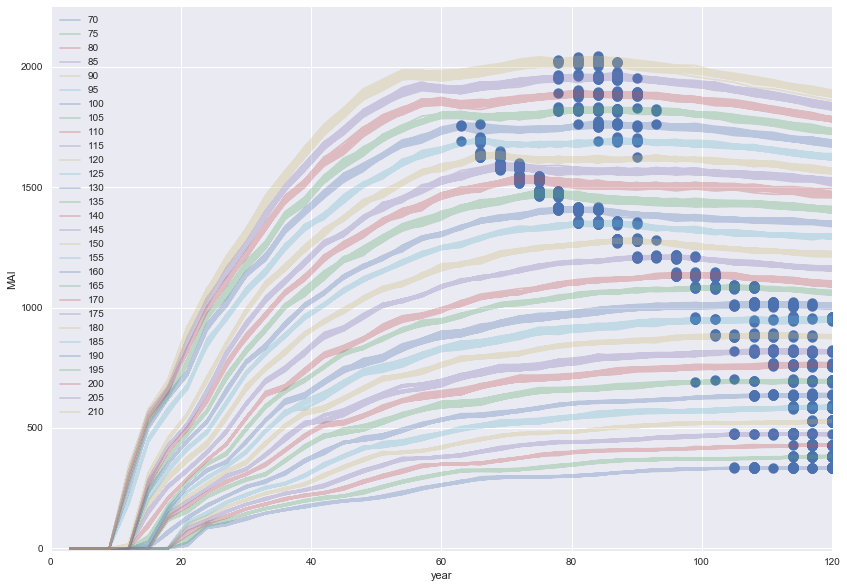

In [217]:
new_group = merged.loc[merged.variant=='WC'].copy()

# get max MAI observed for each stand in each run
idx = new_group[['caseid', 'standid', 'year', 'MAI']].groupby(['caseid', 'standid'])['MAI'].transform(max) == new_group['MAI']

# for PN variant, base age 50
new_group['site_class'] = pd.cut(new_group.SI, bins=[49, 75, 95, 115, 135, 161], labels=['V', 'IV', 'III', 'II', 'I'])
# for WC variant, base age 100
# new_group['site_class'] = pd.cut(new_group.SI, bins=[69, 95, 125, 155, 185, 211], labels=['V', 'IV', 'III', 'II', 'I'])

fig, ax = plt.subplots(figsize=(14,10))
colors = {'I':'#d7191c', 'II':'#fdae61', 'III':'#ffffbf', 'IV':'#abd9e9', 'V':'#2c7bb6'}
for name, group in new_group.groupby('SI'):
    group.plot(x='year', y='MAI', ax=ax, label=name, alpha=0.3)

new_group[idx].plot.scatter(x='year', y='MAI', ax=ax, s=100)

# get best-fit line of rotation ages by site index with np.polyfit
#x=new_group[idx].loc[(new_group.SI > 150) | (new_group.SI < 70)].groupby('SI').median().year
#y=new_group[idx].loc[(new_group.SI > 150) | (new_group.SI < 70)].groupby('SI').median().MAI
#m, b = np.polyfit(x,y, 1)
ax.set_ylim(-10, new_group.MAI.max()*1.10)
#graph_x = range(20,150)
#plt.plot(graph_x, m*graph_x + b, 'k--')
plt.show()

In [207]:
new_group.head()

,caseid,standid,year,after_bdft,rbdft,MAI,SI,variant,site_class
41,001bf202-1768-431e-aaf6-441765ac0415,WC_195,0,0.0,0.0,NaN,195,WC,NaN
42,001bf202-1768-431e-aaf6-441765ac0415,WC_195,3,0.0,0.0,0.000000,195,WC,NaN
43,001bf202-1768-431e-aaf6-441765ac0415,WC_195,6,0.0,0.0,0.000000,195,WC,NaN
44,001bf202-1768-431e-aaf6-441765ac0415,WC_195,9,0.0,0.0,0.000000,195,WC,NaN
45,001bf202-1768-431e-aaf6-441765ac0415,WC_195,12,3425.0,0.0,285.416667,195,WC,NaN


In [212]:
new_group[idx].groupby('SI').median()

,year,after_bdft,rbdft,MAI
SI,,,,
70,114.0,27588.5,10759.5,335.445906
75,120.0,29122.0,16531.0,382.047149
80,117.0,34254.5,16165.5,430.432411
85,114.0,33363.5,20925.0,476.409774
90,120.0,41439.5,21906.5,528.502671
95,117.0,43154.5,26584.0,586.545659
100,114.0,46044.5,27583.0,636.166204
105,117.0,51184.5,28864.0,695.747863
110,117.0,54690.0,34231.5,760.422807


In [134]:
conn = psycopg2.connect("dbname='ShortRotations' user='postgres' host='localhost'") # password in pgpass file
SQL = '''
SELECT caseid, standid, year, pnv
FROM econsummary;
'''
# read the query into a pandas dataframe
ShortRotations = pd.read_sql(SQL, conn)

# close the database connection
conn.close()

In [135]:
ShortRotations['variant'] = ShortRotations['standid'].apply(lambda x: x.split('_')[0])
ShortRotations['site_index'] = ShortRotations['standid'].apply(lambda x: x.split('_')[-1]).astype('int')
# calculate indexes for rows that have the highest PNV for a rotation
short_idx = ShortRotations[['caseid', 'standid', 'year', 'pnv']].groupby(['caseid', 'standid'])['pnv'].transform(max) == ShortRotations['pnv']

C:\Users\ddiaz\AppData\Local\Continuum\Anaconda2\envs\Py3.5\lib\site-packages\ipykernel\__main__.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\ddiaz\AppData\Local\Continuum\Anaconda2\envs\Py3.5\lib\site-packages\ipykernel\__main__.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\ddiaz\AppData\Local\Continuum\Anaconda2\envs\Py3.5\lib\site-packages\ipykernel\__main__.py:24: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


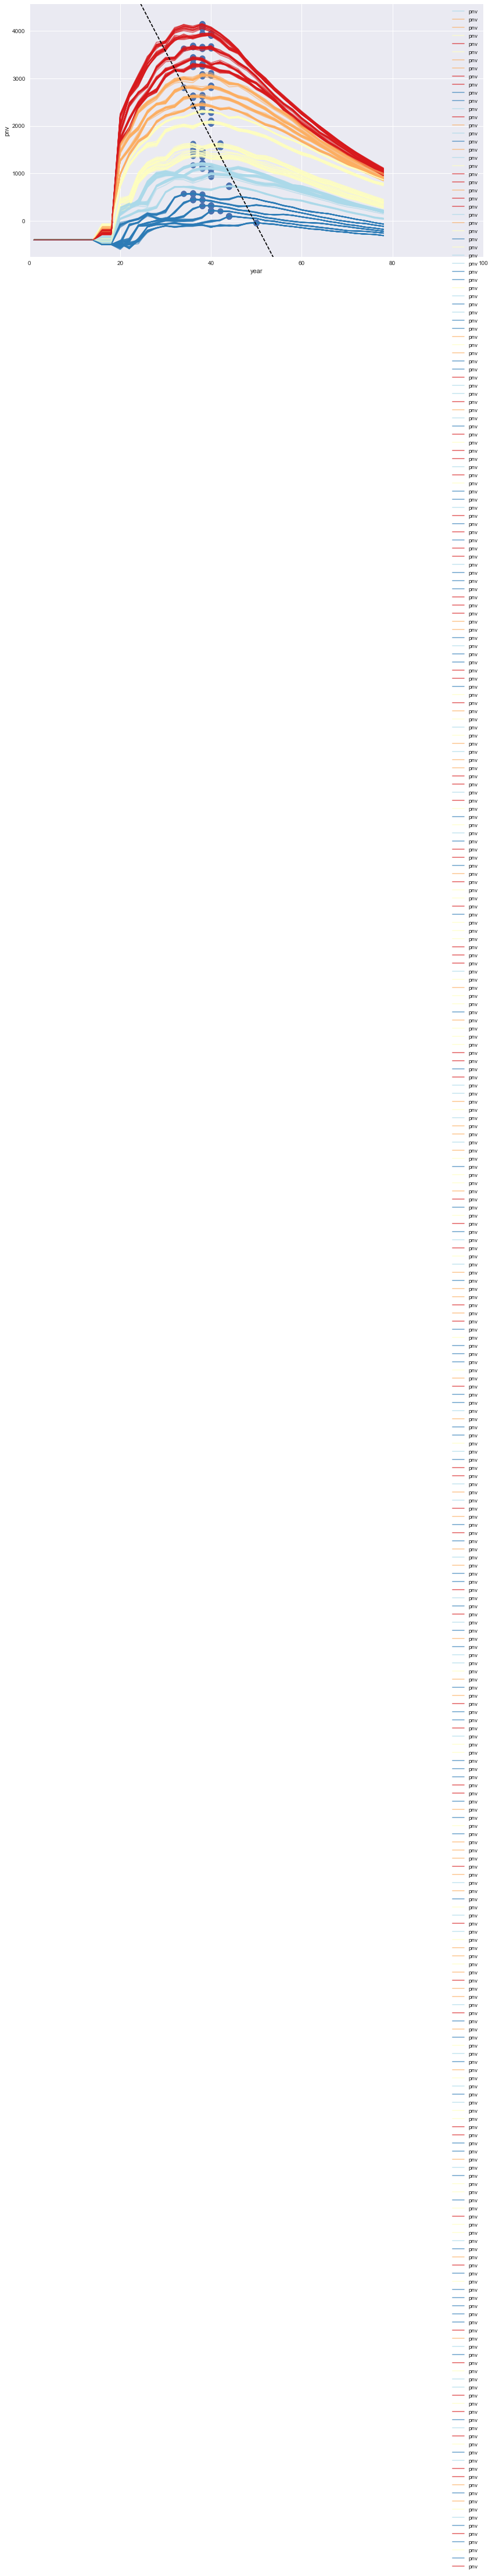

In [138]:
var = 'PN'
var_short = ShortRotations.loc[ShortRotations.variant==var].copy()
if var == 'PN':
    var_short['site_class'] = pd.cut(var_short.site_index, bins=[49, 75, 95, 115, 135, 161], labels=['V', 'IV', 'III', 'II', 'I'])
elif var == 'WC':
    var_short['site_class'] = pd.cut(var_short.site_index, bins=[69, 95, 125, 155, 185, 211], labels=['V', 'IV', 'III', 'II', 'I'])

fig, ax = plt.subplots(figsize=(14,8))
colors = {'I':'#d7191c', 'II':'#fdae61', 'III':'#ffffbf', 'IV':'#abd9e9', 'V':'#2c7bb6'}

for name, group in var_short.groupby(['site_index']):
    group.plot(x='year', y='pnv', ax=ax, color=colors[pd.unique(group.site_class)[0]], alpha=0.6)

ShortRotations[short_idx].loc[ShortRotations.variant==var].plot.scatter(x='year', y='pnv', ax=ax, s=100)

# get best-fit line of rotation ages by site index with np.polyfit
x=var_short[short_idx].year
y=var_short[short_idx].pnv
m, b = np.polyfit(x,y, 1)
ax.set_ylim(var_short.pnv.min()*1.25, var_short.pnv.max()*1.10)
ax.set_xlim(0,100)

graph_x = range(20,60)
plt.plot(graph_x, m*graph_x + b, 'k--')
plt.show()
plt.show()

In [219]:
var = 'PN'
var_short = ShortRotations.loc[ShortRotations.variant==var].copy()
var_short[short_idx].groupby('site_index').median()

C:\Users\ddiaz\AppData\Local\Continuum\Anaconda2\envs\Py3.5\lib\site-packages\ipykernel\__main__.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


,year,pnv
site_index,,
50,50,-35.57955
55,44,102.41200
60,40,214.99700
65,40,323.47900
70,36,451.64800
75,36,577.02100
80,44,735.10500
85,40,988.97700
90,40,1114.56000


In [220]:
var = 'WC'
var_short = ShortRotations.loc[ShortRotations.variant==var].copy()
var_short[short_idx].groupby('site_index').median()

C:\Users\ddiaz\AppData\Local\Continuum\Anaconda2\envs\Py3.5\lib\site-packages\ipykernel\__main__.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


,year,pnv
site_index,,
70,58,-218.9260
75,54,-156.8600
80,50,-90.4371
85,48,-27.5117
90,48,41.6834
95,46,118.2290
100,44,210.9490
105,52,293.5410
110,50,400.6560
